# *1. Загрузка библиотек*

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling as pp
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, roc_curve

In [11]:
RANDOM_STATE = 42

# *2. Загрузка данных*

In [12]:
data_dir = 'data/'
train_df = pd.read_csv(data_dir+'train.csv')
test_df = pd.read_csv(data_dir+'test.csv')

In [13]:
# объединяем тестовую и обучающую выборки в один датафрейм
train_df['test'] = 0
test_df['test'] = 1
df = pd.concat([train_df, test_df], ignore_index=True)

# *3. Обзор и анализ данных* 

In [14]:
# колличество позиций в тестовой и обучающей выборке
df['test'].value_counts()

0    73799
1    36349
Name: test, dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

## *DataSet fields*


    client_id - идентификатор клиента
    education - уровень образования
    sex - пол заемщика
    age - возраст заемщика
    car - флаг наличия автомобиля
    car_type - флаг автомобиля иномарки
    decline_app_cnt - количество отказанных прошлых заявок
    good_work - флаг наличия “хорошей” работы
    bki_request_cnt - количество запросов в БКИ
    home_address - категоризатор домашнего адреса
    work_address - категоризатор рабочего адреса
    income - доход заемщика
    foreign_passport - наличие загранпаспорта
    sna - связь заемщика с клиентами банка
    first_time - давность наличия информации о заемщике
    score_bki - скоринговый балл по данным из БКИ
    region_rating - рейтинг региона
    app_date - дата подачи заявки
    default - флаг дефолта по кредиту

In [16]:
# анализ данных с использованием библиотеки ProfileReport
df_pp = pp.ProfileReport(df)
df_pp

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# *4. Обработка и преобразование данных*

### **default** - целевое значение

In [17]:
df['default'].value_counts()

0.0    64427
1.0     9372
Name: default, dtype: int64

Иммется дисбаланс целевой переменной 1:7, для упрощения обработки данный, а также oversampling/undersempling, отсортируем выборку:<br>
0-9372 - выборка со значением default=1<br>
9373-73798 - выборка со значением default=0<br>
73799-110148 - тестовая выборка

In [18]:
df = pd.concat([df[df['default'] == 1], df[df['default']==0], df[df['test']==1]], ignore_index=True)

### **client_id** - уникальные значения, соответствуют порядковому номеру клиента, параметр не будет использоваться при обучении модели

### **app_data** - дата в формате строки. Будет приобразована в формат DateTime, для дальнейшей генерации новых признаков.

In [19]:
df['app_date'].unique()

array(['02FEB2014', '28FEB2014', '11FEB2014', '02MAR2014', '25FEB2014',
       '17MAR2014', '24FEB2014', '03FEB2014', '05FEB2014', '13MAR2014',
       '30JAN2014', '31MAR2014', '26JAN2014', '15MAR2014', '18MAR2014',
       '08JAN2014', '19APR2014', '30APR2014', '15JAN2014', '10FEB2014',
       '20JAN2014', '17FEB2014', '19JAN2014', '26APR2014', '04APR2014',
       '12MAR2014', '14MAR2014', '18JAN2014', '12FEB2014', '27JAN2014',
       '23JAN2014', '12JAN2014', '12APR2014', '07JAN2014', '16APR2014',
       '22MAR2014', '06MAR2014', '04FEB2014', '01APR2014', '25MAR2014',
       '05MAR2014', '22FEB2014', '30MAR2014', '04MAR2014', '22APR2014',
       '11MAR2014', '16JAN2014', '25APR2014', '14FEB2014', '06APR2014',
       '29JAN2014', '31JAN2014', '29MAR2014', '08APR2014', '03APR2014',
       '15FEB2014', '20MAR2014', '02APR2014', '21FEB2014', '09APR2014',
       '19MAR2014', '07APR2014', '08MAR2014', '28APR2014', '25JAN2014',
       '04JAN2014', '21JAN2014', '26FEB2014', '15APR2014', '16MA

In [20]:
# преобразование значений в DateTime формат
df['app_date'] = pd.to_datetime(df['app_date'], format='%d%b%Y')

создание новых признаков:<br>
-season - сезон<br>
-month - месяц<br>
-weekend - выходные<br>
-days_passed - сколько дней прошло с подачи заявки

In [22]:
df['app_month'] = df['app_date'].apply(lambda x: x.month)
df['app_season']= df['app_date'].apply(lambda x: np.ceil(x.month/3.0))
df['app_weekend'] = df['app_date'].apply(lambda x: x.weekday()>=5)
#т.к. вся выборка от 2014 года, для определения величины периода с момента заявки, возьмем 31.12.2014 как текущее значение
current_day = pd.to_datetime('31DEC2014', format='%d%b%Y')
df['days_passed'] = (current_day - df['app_date']).dt.days

### **education** - категорийный признак. Заполним пропуски самым частым значением. Преобразуем значения в числовые.

In [23]:
#заполнение пустых значений
df['education'] = df['education'].fillna('SCH')
#преобразование в числовые значения в соответствии с их весом
df['education'] = df['education'].apply(lambda x: {'SCH':0, 
                                                       'GRD':1,
                                                       'UGR':2,
                                                       'PGR':3,
                                                       'ACD':4
                                                      }.get(x, 0))

### **sex, car, car_type, good_work, foreign_passport** - бинарные значения. Выделим, для дальнейшего преобразования.

In [24]:
#группировка бинарных значений
bool_var = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'app_weekend']
#кодирование бинарных значений
le = LabelEncoder()
for item in bool_var:
    df[item] = le.fit_transform(df[item])

In [25]:
X_bool = df[bool_var].values #формирование конечной матрицы бинарных значений

### **app_month, app_season, app_weekend, education, home_address, work_address, sna, first_time** - категориальные признаки. Выделим для дальнейшего преобразования.

In [26]:
#группировка категорийных значений
cat_var = ['app_month', 'app_season', 'app_weekend', 'education', 'home_address', 'work_address',
           'sna', 'first_time']

<AxesSubplot:>

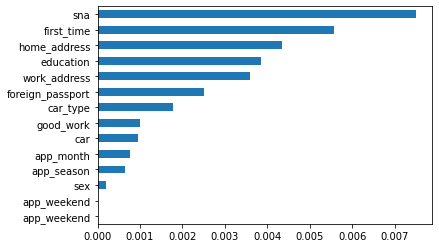

In [27]:
#оценка значимости категорийных значений
imp_cat = pd.Series(mutual_info_classif(df[bool_var+cat_var][df['test']==0], df['default'].dropna(), discrete_features=True),
          index=bool_var+cat_var)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [28]:
#удалим значение app_weekend, т.к. оно имеет наименьшее значение
cat_var.remove('app_weekend')

In [29]:
#кодируем категорийные признаки как one-hot числовой массив
ohe = OneHotEncoder()
ohe.fit(df[cat_var])
X_cat = ohe.transform(df[cat_var]).toarray() #формирование конечной матрицы категорийных значений

### **age, decline_app_cnt, score_bki, bki_request_cnt, region_rating, income** - числовые признаки. Выделим для дальнейшего преобразования и анализа.

In [30]:
#группировка числовых признаков
num_var = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income', 'days_passed']

In [32]:
#преобразования значений score_bki  
df['score_bki'] = df['score_bki'].apply(np.abs)

In [33]:
#генерация дополнительного параметра из имеющихся
df['score_per_bki_request_in_region'] = df['score_bki']**2 / (df['bki_request_cnt']+0.1) * df['region_rating']
#генерация дополнительного параметра из имеющихся
df['score_per_age_in_region'] = df['score_bki'] / df['age'] * df['region_rating']
#df['score_per_age_in_sna'] = (df['score_bki']/df['age'])**df['sna']
#df['score_per_age_in_passport'] = (df['score_bki']/df['age'])**df['foreign_passport']
num_var.extend(['score_per_bki_request_in_region', 'score_per_age_in_region'])

/home/valeriy/Documents/DataScience/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


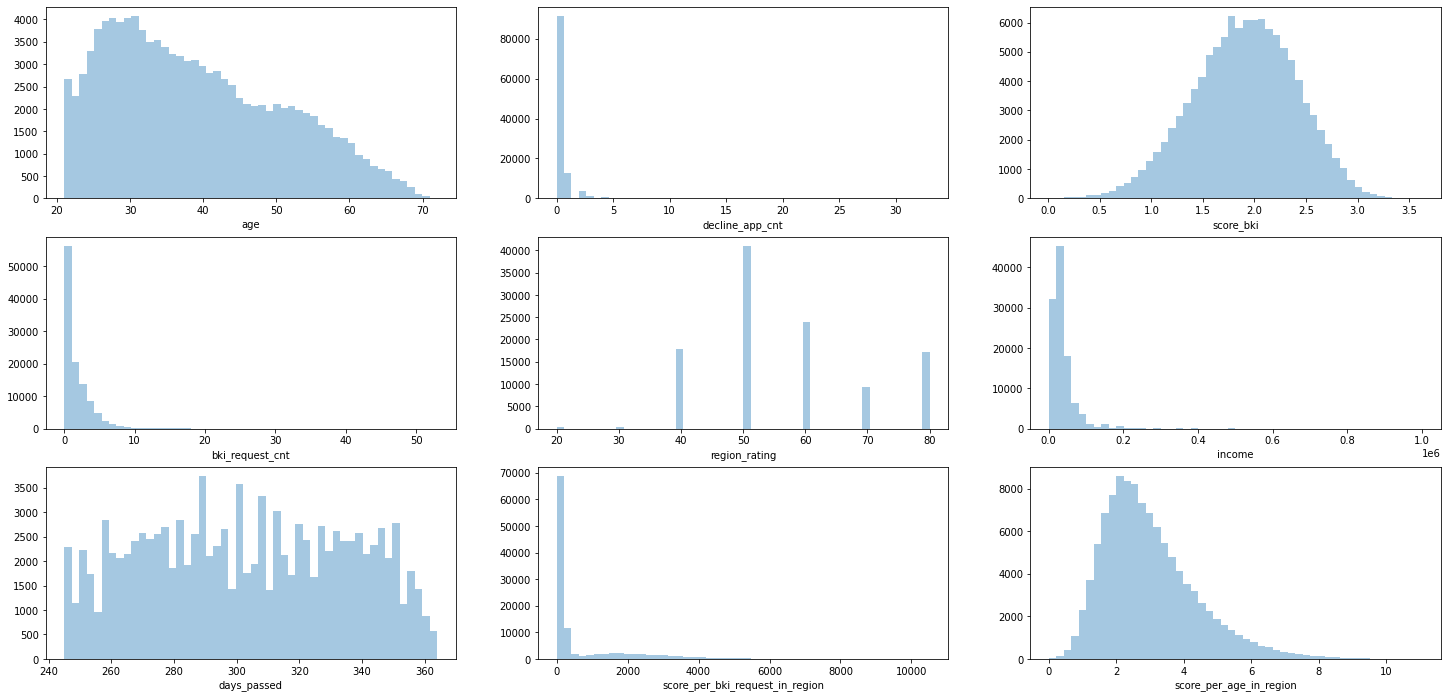

In [35]:
fig, axes = plt.subplots(3, 3, figsize=(25, 12))
for col, i in zip(num_var, range(9)):
    sns.distplot(df[col], kde=False, ax=axes.flat[i])

<AxesSubplot:>

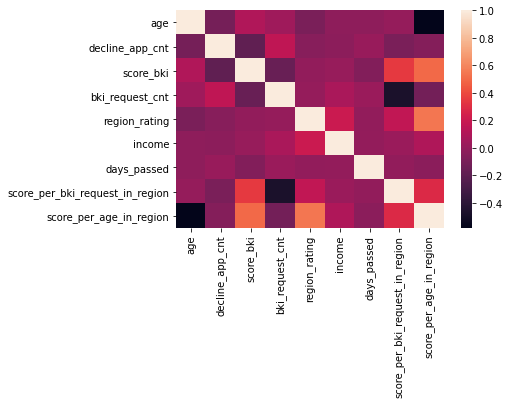

In [38]:
sns.heatmap(df[num_var].corr())

/home/valeriy/Documents/DataScience/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/valeriy/Documents/DataScience/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/valeriy/Documents/DataScience/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

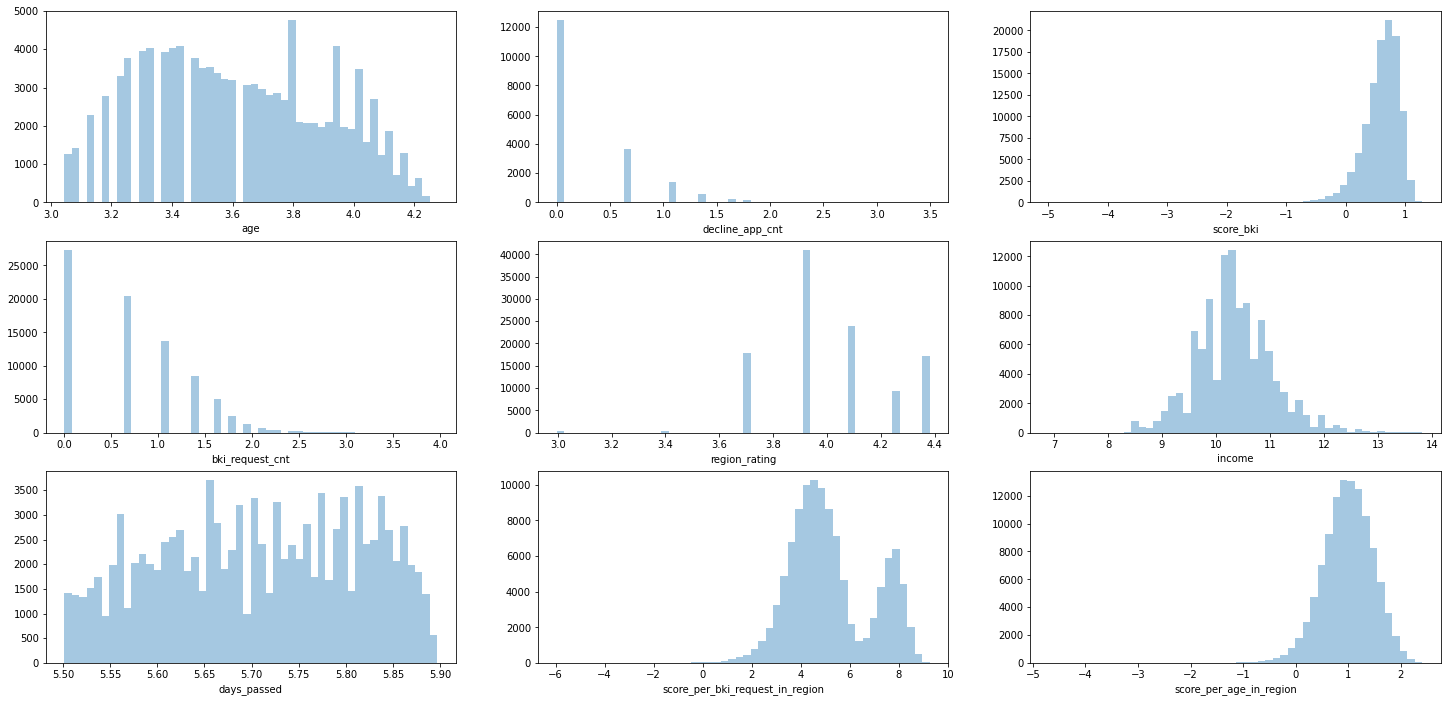

In [39]:
#анализ распределения логорифмированных числовых признаков
fig, axes = plt.subplots(3, 3, figsize=(25, 12))
for col, i in zip(num_var, range(9)):
    sns.distplot(np.log(df[col][df[col] > 0].dropna()), kde=False, ax=axes.flat[i])

<AxesSubplot:>

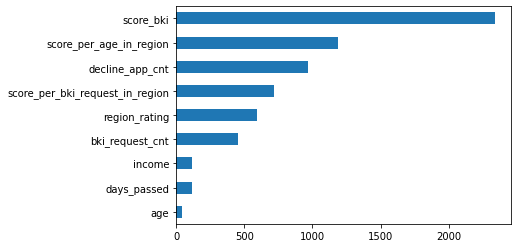

In [40]:
#анализ значимости числовых значений
imp_num = pd.Series(f_classif(df[df['test']==0][num_var], df['default'].dropna())[0], index=num_var)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [41]:
#логорифмируем числовые признаки для лучшей нормализации
for item in num_var:
    df[item] = df[item].apply(lambda x: np.log(x) if x>0 else x)

In [42]:
#стандартизация числовых признаков
ss = StandardScaler()
ss.fit(df[num_var])
X_num = ss.transform(df[num_var]) #формирование конечной матрицы числовых признаков

# 5. Произведем комбинирование признаков различных типов для дальнейшего обучения модели на них и получения результатов из тестовой выборки. 

In [43]:
# объединение всех признаков в единую матрицу
X = np.hstack([X_num, X_cat, X_bool])

In [44]:
# выделяем выборку для обучения модели с равным распределением целевого параментра
X_Train = X[:18744,:]
y_Train = df[df['test']==0]['default'].values[:18744]

# 6. Деление обучающей выборки

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X_Train, y_Train, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)

# 7.1 Поиск гиперпараметров для улучшения показателей модели

In [46]:
"""model = LogisticRegression(random_state=RANDOM_STATE)
#зададим сетку параметров
param_grid = {'penalty': ['l1', 'l2'], 'C': np.logspace(0, 4, 10)}

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
gridsearch = GridSearchCV(model, param_grid, cv=5, verbose=0)
gridsearch.fit(X_train, Y_train)
best_params = gridsearch.best_estimator_.get_params()
print(best_params)"""

"model = LogisticRegression(random_state=RANDOM_STATE)\n#зададим сетку параметров\nparam_grid = {'penalty': ['l1', 'l2'], 'C': np.logspace(0, 4, 10)}\n\n# Создаем сетку поиска с использованием 5-кратной перекрестной проверки\ngridsearch = GridSearchCV(model, param_grid, cv=5, verbose=0)\ngridsearch.fit(X_train, Y_train)\nbest_params = gridsearch.best_estimator_.get_params()\nprint(best_params)"

# 7.2 Обучение модели и предсказание целевых параметров

In [47]:
"""model = LogisticRegression(**best_params)
model.fit(X_train, Y_train)
Y_pred_proba = model.predict_proba(X_test)[:,1]
Y_pred = model.predict(X_test)"""

'model = LogisticRegression(**best_params)\nmodel.fit(X_train, Y_train)\nY_pred_proba = model.predict_proba(X_test)[:,1]\nY_pred = model.predict(X_test)'

## 7.2.1 Обучение с помощью модели LogisticRegressionCS

In [48]:
model = LogisticRegressionCV(cv=5, random_state=RANDOM_STATE)
model.fit(X_train, Y_train)
Y_pred_proba = model.predict_proba(X_test)[:,1]
Y_pred = model.predict(X_test)

# 8. Расчет и анализ метрик для оценки модели.

In [49]:
#ROC AUC metrics
roc_auc = roc_auc_score(Y_test, Y_pred_proba)
print(roc_auc)

0.7316650700109346


In [50]:
# confusion matrix
confusion_matrix(Y_test, Y_pred, labels=[1,0])

array([[1247,  640],
       [ 597, 1265]])

In [51]:
#f1 Score metric
f1_score(Y_test, Y_pred, zero_division=1)

0.6684534977217904

#### визуализация результата

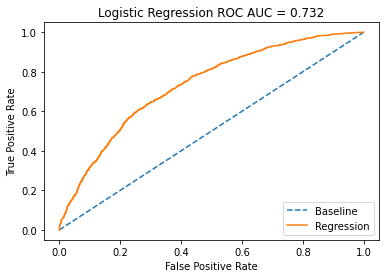

In [52]:
fpr, tpr, threshold = roc_curve(Y_test, Y_pred_proba)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# 9. Получение целевых данных из тестовой выборки

In [53]:
#выделение тестовой выборки
X_target = X[73799:,:]
#получение результата
y_pred_proba = model.predict_proba(X_target)[:,1]


In [54]:
#запись результатов
submission = pd.DataFrame(
    {"client_id": test_df['client_id'] , "default": y_pred_proba})
submission.to_csv("submission.csv", index=False)
submission.head()

client_id   default
0      74835  0.216723
1      17527  0.791644
2      75683  0.294207
3      26883  0.454955
4      28862  0.168850